# LOOCV results

In [2]:
from ast import literal_eval  
import math   
import matplotlib.pyplot as plt
import numpy as np
import os  
import pandas as pd
import seaborn as sns
import time

from collections import defaultdict
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection   

In [5]:
datasetTimepoint = "12_uponAdmission"
target = "disease_severity"
#### Feature selection:
vars = "boruta"    # boruta+bestSterols
varPath = f"../../results/featureSelection/{datasetTimepoint}/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()

folder = f"../../results/prediction/featureSelection/{datasetTimepoint}/{vars}/modelComparison/zigaPipeline"
folderFigures =  f"../../figures"
os.makedirs(folderFigures, exist_ok=True)

#model = "rfc"

In [6]:
''' Load data'''
dataframes_before = {}
dataframes_after = {} 
dataframes_features = {} 
dataframes_importances = {} 

models = ['rfc', 'gpr', 'abc','log', 'knn', 'mlp', 'gnb', 'qda', 'mcl'] #'svc'

# Scoring

## Scoring different models

In [7]:
df_scoring = pd.DataFrame()
for model in models:
    df = pd.read_csv(folder+f"/prediction_cv_test_{model}.csv")   
    df_scoring = pd.concat([df_scoring, df], axis=0)

df_scoring.to_csv(f"{folderFigures}/LOOCV_modelComparison_scoring.csv", index=False)
df_scoring

,precision,recall,f1,accuracy,model,auc
0,0.933824,0.947761,0.940741,0.902439,rfc,0.949005
0,0.913669,0.947761,0.930403,0.884146,gpr,0.944279
0,0.910448,0.910448,0.910448,0.853659,abc,0.755224
0,0.919708,0.940299,0.929889,0.884146,log,0.942289
0,0.896000,0.835821,0.864865,0.786585,knn,0.705846
0,0.838926,0.932836,0.883392,0.798780,mlp,0.625373
0,0.976000,0.910448,0.942085,0.908537,gnb,0.954726
0,0.952756,0.902985,0.927203,0.884146,qda,0.919900
0,0.817073,1.000000,0.899329,0.817073,mcl,0.500000


Text(0.5, 1.0, 'clinical')

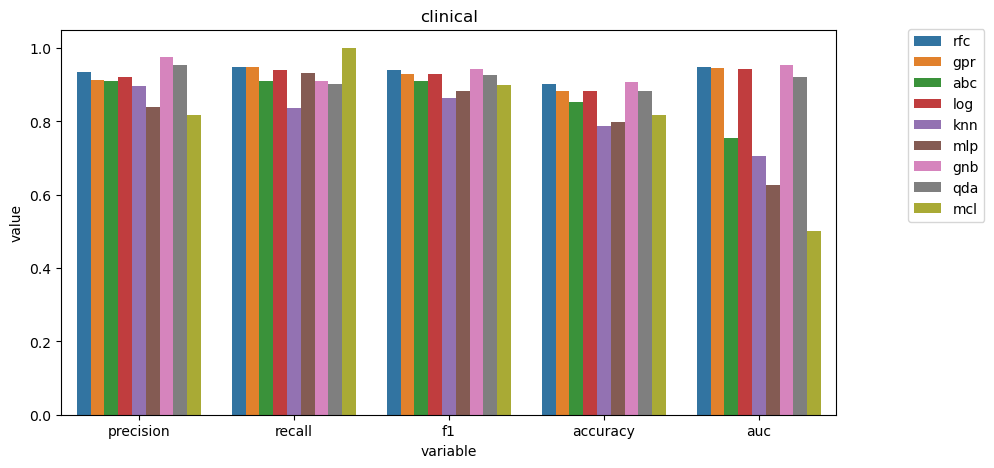

In [7]:
df_scoring_plot = df_scoring.melt("model")

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=df_scoring_plot, x="variable", y="value", hue="model")
ax.legend(bbox_to_anchor=(1.2, 1.02))
ax.set_title("clinical")

In [6]:
df_scoring.index=df_scoring["model"]
df_scoring_bestModel = df_scoring.drop(["model"], axis=1)
df_scoring_bestModel.idxmax()

precision    gnb
recall       mcl
f1           gnb
accuracy     gnb
auc          gnb
dtype: object

## Feature importances (1 model)

In [11]:
models = ["gnb"]
df_importances = pd.read_csv(folder + f"/importances_test_{models[0]}.csv")   

#get distribution of selection ratio
df_importances_sf = df_importances.copy()  
df_importances_sf["n"] = np.sum(df_importances_sf.iloc[:,1:-1] > 0, axis = 1) 
N = len(df_importances_sf.columns) - 3
df_importances_sf["importance"] = df_importances_sf["n"]/N    

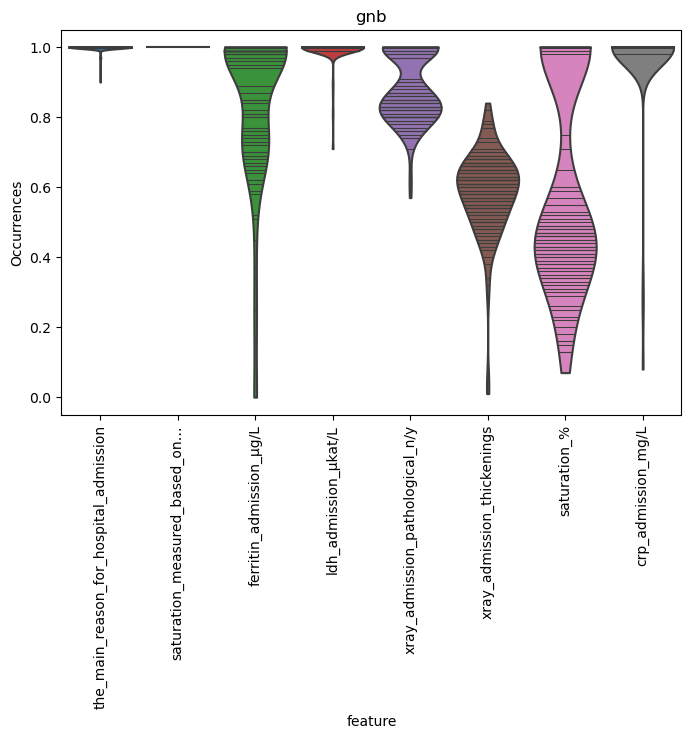

In [12]:
fig, axes = plt.subplots(len(models), 1, figsize=(8,5))  
for index, model in enumerate(models):    
    df_importances_sf_model = df_importances_sf[df_importances_sf.model == model] 
      
    ax = sns.violinplot(data=df_importances_sf_model, inner="stick", ax=axes, x="feature", y="importance",  order=sel_variables, cut=0, scale="width") #color = sns.color_palette("hls", 8)[5]     
    ax.set_ylabel("Occurrences")    #axes[index]
    ax.set_title(model)
    ax.tick_params(axis='x', rotation=90)

## Feature importances comparison between multiple models

In [41]:
def evaluate_fi(df_importances):
    df_importances_sf = df_importances.copy()  
    df_importances_sf["n"] = np.sum(df_importances_sf.iloc[:,1:-1] > 0, axis = 1) 
    N = len(df_importances_sf.columns) - 3
    df_importances_sf["importance"] = df_importances_sf["n"]/N    
    return df_importances_sf

In [52]:
df_fi = pd.DataFrame()
models = ["gnb", "rfc"]

for model in models:
    df = pd.read_csv(f"{folder}/importances_test_{model}.csv") 
    df = evaluate_fi(df)
    df["model"] = model
    df_fi = pd.concat([df_fi, df], axis=0)

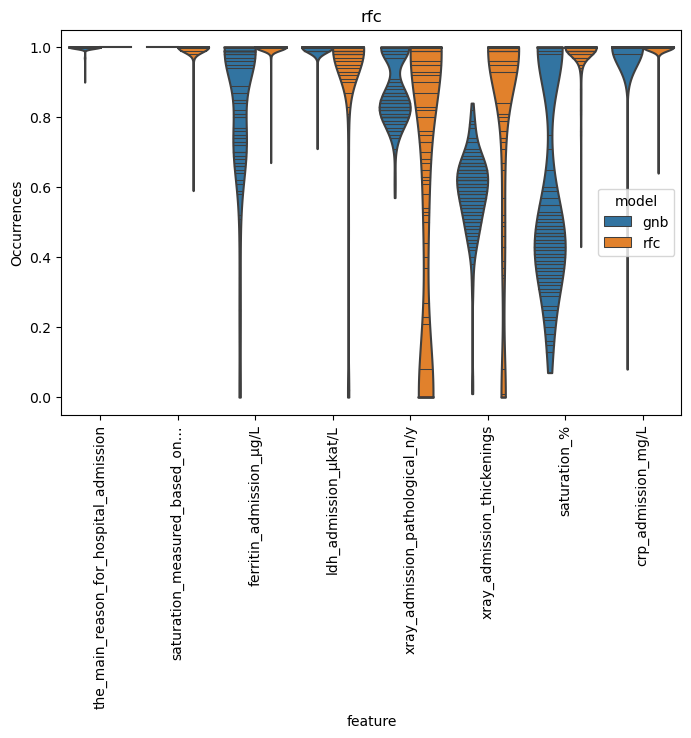

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(8,5)) 
ax = sns.violinplot(data=df_fi, inner="stick", ax=axes, x="feature", y="importance", hue="model", order=sel_variables, cut=0, scale="width") #color = sns.color_palette("hls", 8)[5]     
ax.set_ylabel("Occurrences")    #axes[index]
ax.set_title(models)
ax.tick_params(axis='x', rotation=90)